In [4]:
import sqlalchemy
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)

url_object = sqlalchemy.engine.URL.create(
    "postgresql+psycopg2",
    username="pguser",
    password="pgpass",
    host="localhost",
    database="finance_dwh",
    port=5431
)

engine = sqlalchemy.create_engine(
    url_object)

query_str = """select 
country,day,average_temperature,avg_max_temp,avg_min_temp,average_temperature_day,hdd
from 
country_weather_history 
 
"""
temperature_df = pd.read_sql_query(query_str, con=engine)
temperature_df['day'] = pd.to_datetime(temperature_df['day'], format='%Y-%m-%d')

In [5]:


query_str = """select 
country_code country, 
amount, 
time_period from 
eu_lng_consumptions 
where 
energy_balance = 'IC_OBS' and 
unit = 'MIO_M3' 
order by time_period desc
"""

df = pd.read_sql_query(query_str, con=engine)

df = df[df['amount'].notna()]
df['month'] = pd.to_datetime(df['time_period'], format='%Y-%m-%d')
df = df[~(df['month'] < '2015-01-01')]
df = df[~(df['month'] > '2022-12-31')]
df['day'] = df['month'].apply(pd.date_range, freq='MS', periods=2).apply(lambda ds: pd.date_range(*ds, closed='left'))
df['amount'] /= df['day'].apply(len)
df =df.explode('day')
df['day'] = pd.to_datetime(df['day'])
gas_consumption_df = df

/tmp/ipykernel_633475/774033934.py:18: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  df['day'] = df['month'].apply(pd.date_range, freq='MS', periods=2).apply(lambda ds: pd.date_range(*ds, closed='left'))


In [6]:
from sklearn.linear_model import LinearRegression

combined_df = temperature_df.merge(gas_consumption_df, on=['country', 'day'], how='inner')
# Create a new column 'A_Coefficient' in both dataframes and initialize with NaN
temperature_df['A_Coefficient'] = np.nan
gas_consumption_df['A_Coefficient'] = np.nan

# Group the data by 'Country' and calculate the coefficient for each group
for country, group in combined_df.groupby('country'):
    print(country)
    regression_model = LinearRegression()
    X = group[['hdd']].values
    y = group['amount'].values
    regression_model.fit(X, y)
    a_coefficient = regression_model.coef_[0]

    # Assign the coefficient to the respective rows in both dataframes
    temperature_df.loc[temperature_df['country'] == country, 'A_Coefficient'] = a_coefficient
    gas_consumption_df.loc[gas_consumption_df['country'] == country, 'A_Coefficient'] = a_coefficient
    combined_df.loc[combined_df['country'] == country, 'A_Coefficient'] = a_coefficient


BE
BG
CY
ES
FI
FR
HR
HU
IT
LT
LU
MT
NL
PL
RO
SE
SI


In [7]:

import pandas as pd


query_str = """select 
country,
day,
sum(average_temperature * city_population) / sum(city_population) average_temperature
from 
country_weather_forecasts 
 group by country, day
"""
forecasts = pd.read_sql_query(query_str, con=engine).to_dict('records')


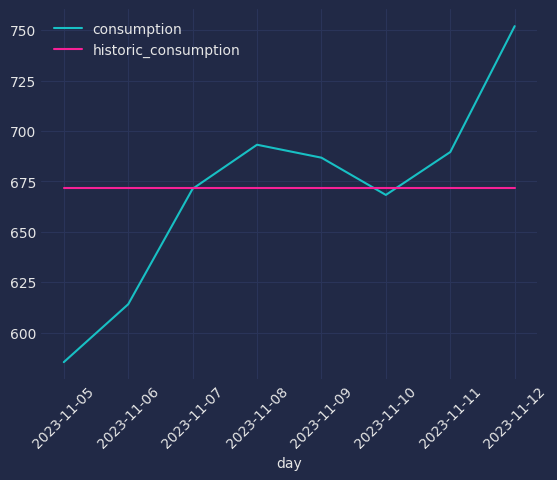

In [9]:
def calculate_expected_gas_consumption(current_temperature, average_temperature, average_gas_consumption, a_coefficient):
    # Calculate the Heating Degree Days (HDD)
    hdd = average_temperature - current_temperature
    
    # Calculate the expected gas consumption
    expected_gas_consumption = average_gas_consumption + (hdd * a_coefficient)
    
    return expected_gas_consumption

import matplotlib.pyplot as plt
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")
from datetime import date as dt, timedelta
dates = [(dt.today() + timedelta(x)) for x in range(1,9)]
data = []
for day in dates:
    country_stats = combined_df[combined_df['day'] == day.strftime('2022-%m-13')].to_dict('records')
    for country in country_stats:
        expected_temperature = [x['average_temperature'] for x in forecasts 
            if x['day'].strftime('%Y-%m-%d') == day.strftime('%Y-%m-%d') and x['country'] == country['country']][0]
        expected_consumption = calculate_expected_gas_consumption(
            expected_temperature, country['average_temperature_day'], country['amount'], country['A_Coefficient'])
        row = {
            'day': day.strftime('%Y-%m-%d'),
            'country': country['country'],
            'consumption': expected_consumption,
            'historic_consumption': country['amount']
            
        }
        data.append(row)

df = pd.DataFrame(data)
sum_df = df.groupby(['day']).agg({'consumption': 'sum', 'historic_consumption': 'sum'})
sum_df.plot()
plt.xticks(rotation = 45)

plt.show()